This notebook walks through the basics of how to use the MedSAM model to segment (1) a CT scan, and (2) a brain MRI. This uses the out-of-the-box MedSAM model, and does not include any finetuning on the HCP dataset.

This notebook is useful to understand the steps involved in this model's inference

In [ ]:
import nibabel as nib
import numpy as np
print(np.__version__)

In [3]:
# %% environment and functions
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F

# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )
    
    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


In [5]:
#%% load model and image
MedSAM_CKPT_PATH = "/gpfs/home/kn2347/MedSAM/medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


## Try demo image first

In [9]:
data_mri = io.imread('/gpfs/home/kn2347/MedSAM/img_demo.png')
data_mri.shape

(512, 512)

In [20]:
paths = ['/gpfs/home/kn2347/MedSAM/img_demo.png']
#for idx, p in enumerate(tqdm(paths)):
for p in paths:

    data_mri = io.imread(p)

    x = data_mri.astype('uint8')
    if len(x.shape) == 2:
        x = np.repeat(x[:, :, None], 3, axis=-1)

    x_3c = x
    x = transform.resize(x, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
    
    #x_tensor_preproc = medsam_model.preprocess(x_tensor) # mean-sd normalizes and pads to square input
    x_tensor_preproc = (x - x.min()) / np.clip(
        x.max() - x.min(), a_min=1e-8, a_max=None
    )
    x_tensor_preproc = torch.tensor(x_tensor_preproc).float().permute(2,0,1).unsqueeze(0)
    #print(torch.Tensor.float(x_tensor_preproc).mean())

    x_tensor_preproc = x_tensor_preproc.to('cuda:0')
    #print(f'okhaha {x_tensor.mean()}')

    
    with torch.no_grad():
        embedding = medsam_model.image_encoder(x_tensor_preproc) # shape is (1, 256, 64, 64)

    #box_o = [[95,255, 190, 350]]
    box_o = [[95,255, 190, 350]]
    box_1024 = box_o / np.array([512, 512, 512, 512]) * 1024
    medsam_seg = medsam_inference(medsam_model, embedding, box_1024, 512, 512)


    # save embedding to a file
    #np.save(f'{folder_dir}/{slice}.npy', embedding.cpu().numpy()[0, :, : ,:])
        

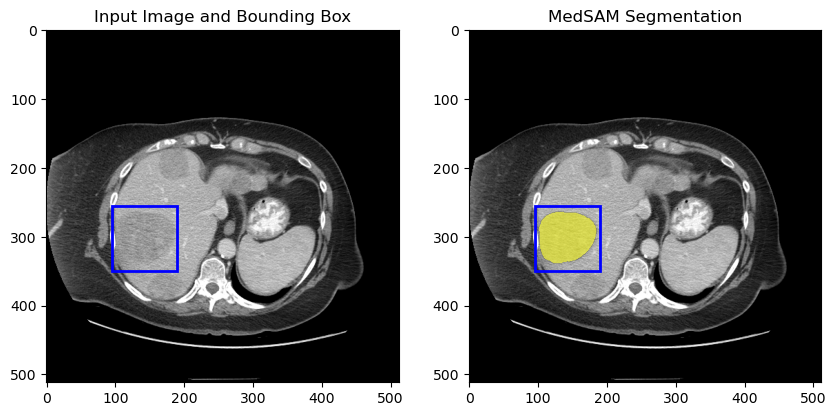

In [21]:
#%% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(x_3c)
show_box(box_o[0], ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(x_3c)
show_mask(medsam_seg, ax[1])
show_box(box_o[0], ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()

In [ ]:

paths = glob.glob('/gpfs/data/cbi/hcp/hcp_seg/data_orig/*/mri/T1.mgz')
root = '/gpfs/data/luilab/karthik/pediatric_seg_proj/hcp_ya_slices_npy/pretrained_image_encoded_slices'

paths = ['/gpfs/data/cbi/hcp/hcp_seg/data_orig/100206/mri/T1.mgz']
#for idx, p in enumerate(tqdm(paths)):
for p in paths:
    id = p.split('/')[-3]

    folder_dir = f'{root}/{id}'
    if not os.path.exists(folder_dir):
        os.makedirs(folder_dir)
    

    data_mri = nib.load(p).get_fdata()

    for slice in range(data_mri.shape[1]):
        if slice != 128:
            continue
        x = data_mri[:,slice,:].astype('uint8')
        if len(x.shape) == 2:
            x = np.repeat(x[:, :, None], 3, axis=-1)

        
        x = transform.resize(x, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
        
        #x_tensor_preproc = medsam_model.preprocess(x_tensor) # mean-sd normalizes and pads to square input
        x_tensor_preproc = (x - x.min()) / np.clip(
            x.max() - x.min(), a_min=1e-8, a_max=None
        )
        x_tensor_preproc = torch.tensor(x_tensor_preproc).float().permute(2,0,1).unsqueeze(0)
        #print(torch.Tensor.float(x_tensor_preproc).mean())

        x_tensor_preproc = x_tensor_preproc.to('cuda:0')

        
        with torch.no_grad():
            embedding = medsam_model.image_encoder(x_tensor_preproc) # shape is (1, 256, 64, 64)

        medsam_seg = medsam_inference(medsam_model, embedding, np.array([[400,400, 600, 600]]), 256, 256)


        # save embedding to a file
        #np.save(f'{folder_dir}/{slice}.npy', embedding.cpu().numpy()[0, :, : ,:])
        

In [13]:
id = '100206'
slice_num = 128

img = nib.load(f'/gpfs/data/cbi/hcp/hcp_seg/data_orig/{id}/mri/T1.mgz').get_fdata()[:, slice_num , :]
x = np.load(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/hcp_ya_slices_npy/pretrained_image_encoded_slices/{id}/{slice_num}.npy')
y = np.load(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/hcp_ya_slices_npy/segmentation_slices/{id}/seg_{slice_num}.npy')

print(x.shape)
print(y.shape)

box = np.array([[100,95,160,125]])
box = box / np.array([256, 256, 256, 256]) * 1024

x_tensor = torch.Tensor(x[None, :, : ,:]).to('cuda')
res = medsam_inference(medsam_model.to('cuda'), x_tensor, box, H=256, W=256)

(256, 64, 64)
(256, 256)


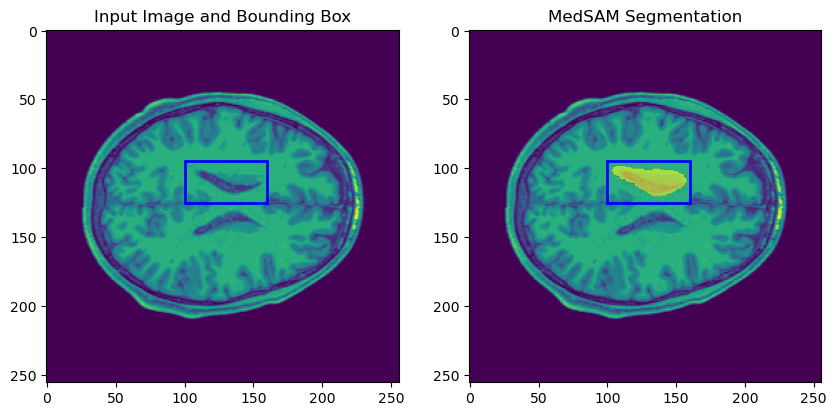

In [14]:
#%% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
show_box(box[0]/1024*256, ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(img)
show_mask(res, ax[1])
show_box(box[0]/1024*256, ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()

In [31]:
from PIL import Image

img = nib.load('/gpfs/data/cbi/hcp/hcp_seg/data_orig/100206/mri/T1.mgz').get_fdata()[:, 128 , :]
img = np.repeat(img[:,:,None], 3, axis = -1).astype('uint8')
im = Image.fromarray(img)
im.save('100206_slice128.png')